In [1]:
%matplotlib inline
import bioread
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
import os
import pickle

In [2]:
class Segment(object):
    def __init__(self, name, start_index_text, start_index, seg_before):
        self.name = name
        self.start_index_text = start_index_text
        self.start_index = start_index
        self.end_index_text = ""
        self.end_index = 0
        self.before = seg_before
        self.after = None
        self.marker_inside_text = ""
        self.marker_inside_index = 0

    def make_df(self, file):
        data = {}
        for channel in file.named_channels:
            signal = np.array(file.named_channels[channel].data[self.start_index:self.end_index])
            data[channel] = signal
        self.df = pd.DataFrame(data)
        print('Dataframe of {0}:'.format(self.name))
        #print(self.df)


In [3]:
class Filedata(object):
    def __init__(self, filename):
        self.filename = filename
        self.segments = {}

    def preparedata(self):
        name_seg_before = None
        name_seg_after = None
        file = bioread.read_file('../RAW_data/labeled/{0}.acq'.format(self.filename))
        for m in file.event_markers:
            if m.text == 'post nf1_VR (crashed)' and self.filename == 'PB1_only_part2':
                continue

            if m.text == 'recording interrupted' and self.filename == 'PB12':
                m.text = 'stress2_MIST_end'

            if m.text == 'stress1_ABBA_start' and m.sample_index == 946410 and self.filename == 'PB13':
                m.text = "stress1_ABBA_end"

            if m.text == 'stress2_MIST_end' and self.filename == 'PB23':
                m.text = "stress1_MIST_end"

            if m.text == '' and self.filename == 'PB27':
                m.text = "nf2_VR_start"

            if m.text == '' and self.filename == 'PB15':
                m.text = "nf2_VR_end"

            if m.text == '' and self.filename in ['PB4', 'PB16', 'PB22', 'PB25', 'PB12-partie_2']:
                continue

            if m.text == 'baseline':
                name = m.text
                current_seg = Segment(name, m.text, m.sample_index, name_seg_before)
                self.segments[name] = current_seg
                name_seg_before = name
            elif m.text.startswith("Segment "):
                continue
            elif m.text.endswith("_start"):
                name = m.text.removesuffix("_start")
                current_seg = Segment(name, m.text, m.sample_index, name_seg_before)
                self.segments[name] = current_seg
                if name_seg_before != None:
                    self.segments[name_seg_before].after = name
                name_seg_before = name
            elif m.text.endswith("_end"):
                name = m.text.removesuffix("_end")
                current_seg = self.segments[name]
                current_seg.end_index_text = m.text
                current_seg.end_index = m.sample_index
                current_seg.make_df(file)
                name_seg_before = name
            elif m.text.endswith("_unlimited"):
                if name_seg_before != None:
                    print("unlimited: " + m.text)
                    self.segments[name_seg_before].marker_inside_text = m.text
                    self.segments[name_seg_before].marker_inside_index = m.sample_index
            else:
                print("unknown: " + m.text)
            print(m.text)

        if self.filename in ['PB4', 'PB7', 'PB12', 'PB13', 'PB14', 'PB15', 'PB16', 'PB17', 'PB21', 'PB25']:
            current_seg = self.segments['baseline']
            current_seg.end_index_text = self.segments['stress1_ABBA'].start_index_text
            current_seg.end_index = self.segments['stress1_ABBA'].start_index
            current_seg.make_df(file)

        if self.filename in ['PB2', 'PB3', 'PB5', 'PB19', 'PB22', 'PB23', 'PB24', 'PB26', 'PB27']:
            current_seg = self.segments['baseline']
            current_seg.end_index_text = self.segments['stress1_MIST'].start_index_text
            current_seg.end_index = self.segments['stress1_MIST'].start_index
            current_seg.make_df(file)

        if self.filename in ['PB12-partie_2']:
            current_seg = self.segments['baseline']
            current_seg.end_index_text = self.segments['stress2_MIST'].start_index_text
            current_seg.end_index = self.segments['stress2_MIST'].start_index
            current_seg.make_df(file)
   

In [4]:
def ECG_report(df, name, fnam):
    print('Segment {0}.{1}:'.format(fnam, name))
    nk.signal_plot(df, subplots=True, sampling_rate=1000)
    #fig = plt.gcf()
    #fig.savefig("all_{0}.png".format(name))
    plt.show()
    plt.close()

    print('ECG of segment {0}.{1}:'.format(fnam, name))
    nk.signal_plot(df['ECG (.5 - 35 Hz)'], sampling_rate=1000)
    plt.grid(True)
    plt.xlim(0, 10)
    plt.ylim(-0.5,0.5)
    #fig = plt.gcf()
    #fig.savefig("ecg_{0}.png".format(name))
    plt.show()
    plt.close()
    # Find peaks
    peaks, info = nk.ecg_peaks(df['ECG (.5 - 35 Hz)'], sampling_rate=1000)
    # Compute HRV indices
    hrv = nk.hrv_time(peaks, sampling_rate=1000, show=True)
    plt.title('ECG Peaks of {0}.{1}:'.format(fnam, name))
    plt.grid(True)
    #fig = plt.gcf()
    #fig.savefig("hrv_{0}_{1}.png".format(fnam, name))
    plt.show()
    plt.close()
    print('HRV of segment {0}.{1}:'.format(fnam, name))
    print(hrv)
    #for col in hrv:
    #    print(col)
    print(hrv['HRV_MeanNN'])
    #print(hrv.iloc[0]['HRV_MeanNN'])
    print(hrv['HRV_SDNN'])
    #print(hrv.iloc[0]['HRV_SDNN'])
    print(hrv['HRV_RMSSD'])
    #print(hrv.iloc[0]['HRV_RMSSD'])

    # Preprocess ECG signal
    signals, info = nk.ecg_process(df['ECG (.5 - 35 Hz)'], sampling_rate=1000)
    # Visualize
    nk.ecg_plot(signals, info)
    #fig = plt.gcf()
    #fig.savefig("ecg_proccess_{0}_{1}.png".format(fnam, name))
    plt.show()
    plt.close()
    # Analyze
    analyze_df = nk.ecg_analyze(signals, sampling_rate=1000)
    print('ECG analyze output of segment {0}.{1}:'.format(fnam, name))
    print(analyze_df)
    #for col in analyze_df:
    #    print(col)
    print(analyze_df['HRV_MeanNN'].apply(lambda x: np.array(x).flatten()[0]))
    #print(analyze_df['HRV_MeanNN'].iloc[0][0][0])
    print(analyze_df['HRV_SDNN'].apply(lambda x: np.array(x).flatten()[0]))
    #print(analyze_df.iloc[0]['HRV_SDNN'][0][0])
    print(analyze_df['HRV_RMSSD'].apply(lambda x: np.array(x).flatten()[0]))
    #print(analyze_df.iloc[0]['HRV_RMSSD'][0][0])


In [5]:
def EDA_report(df, name, fnam):
    #reportname = 'EDAreport_{0}.html'.format(name)
    #signals, info = nk.eda_process(df['EDA (0 - 35 Hz)'], sampling_rate=1000, report=reportname)
    #signals, info = nk.eda_process(df['EDA (0 - 35 Hz)'], sampling_rate=1000, report="text")
    signals, info = nk.eda_process(df['EDA (0 - 35 Hz)'], sampling_rate=1000)
    nk.eda_plot(signals, info)
    plt.grid(True)
    #fig = plt.gcf()
    #fig.savefig("eda_{0}_{1}.png".format(fnam, name))
    plt.show()
    plt.close()
    print('EDA of segment {0}.{1}:'.format(fnam, name))
    #print(signals)
    #print(info)
    analyze_df = nk.eda_analyze(signals, sampling_rate=1000)
    print(analyze_df)



In [6]:
def sort_filelist(l):
    import re
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum = lambda key: [convert(c) for c in re.split(r'PB(\d+)', key)]
    l.sort(key=alphanum)
    return l

In [7]:
def main():
    #fdatas = {}
    #labeled_files = os.listdir('../RAW_data/labeled')
    #for lbfile in sort_filelist(labeled_files):
    #    if lbfile.endswith(".acq"):
    #       filename = lbfile.removesuffix(".acq")
    #       print(filename)
    #       fdata = Filedata(filename)
    #       fdata.preparedata()
    #       fdatas[filename] = fdata

    with open('../dataframes.pkl', 'rb') as f:
        fdatas = pickle.load(f)
    
    for fnam, fdat in fdatas.items():
        print('\nFile {0}:'.format(fnam))
        for name, seg in fdat.segments.items():
            ECG_report(seg.df, name, fnam)
            EDA_report(seg.df, name, fnam)
            #pass

        print('\nFor file {0}:'.format(fnam))
        for name, seg in fdat.segments.items():
            if seg.marker_inside_index != 0:
                print(seg.marker_inside_index)
                print('segment: [{0}] before: [{1}] after [{2}] start [{3}] end [{4}] marker_inside label[{5}] marker_inside index [{6}]'.format(name, seg.before, seg.after, seg.start_index, seg.end_index, seg.marker_inside_text, seg.marker_inside_index))
            else:
                print('segment: [{0}] before: [{1}] after [{2}] start [{3}] end [{4}]'.format(name, seg.before, seg.after, seg.start_index, seg.end_index))
        #first = ""
        #for name, seg in segments.items():
        #    if seg.before == None:
        #        first = name
        #        break
        #seg = segments[first]
        #while True:
        #    print(seg.name)
        #    if seg.after == None:
        #        break
        #    seg = segments[seg.after]
        #In Python 3.6+ dictionaries preserve insertion order.
        #sys.exit(0)
    return 0


File PB1 (only part2):
Segment PB1 (only part2).stress2_ABBA:


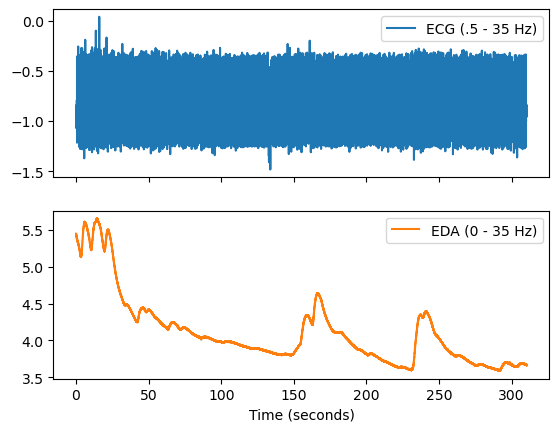

ECG of segment PB1 (only part2).stress2_ABBA:


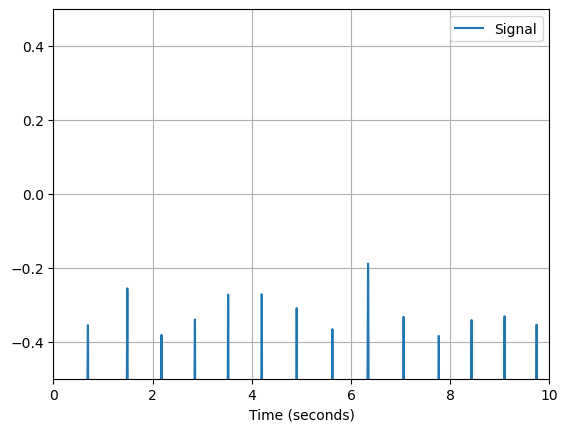

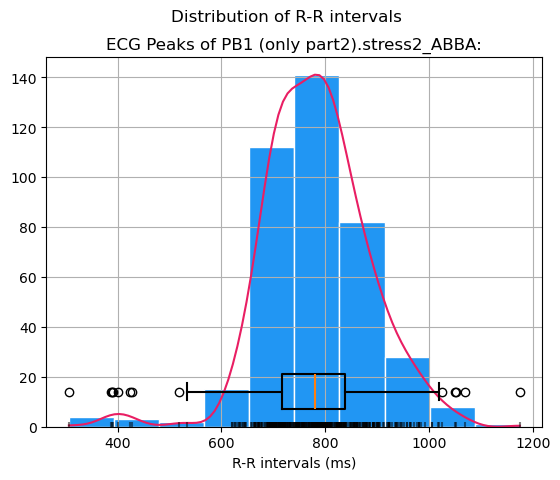

HRV of segment PB1 (only part2).stress2_ABBA:
   HRV_MeanNN    HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  781.828283  105.784475   27.763008  102.618978   26.699003   103.86276   

   HRV_SDANN5  HRV_SDNNI5   HRV_RMSSD    HRV_SDSD  ...  HRV_IQRNN  \
0         NaN         NaN  100.187482  100.312086  ...      122.0   

   HRV_SDRMSSD  HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  \
0     1.055865        706.0        859.0  40.656566  68.939394      306.0   

   HRV_MaxNN  HRV_HTI  HRV_TINN  
0     1175.0     22.0   421.875  

[1 rows x 25 columns]
0    781.828283
Name: HRV_MeanNN, dtype: float64
0    105.784475
Name: HRV_SDNN, dtype: float64
0    100.187482
Name: HRV_RMSSD, dtype: float64


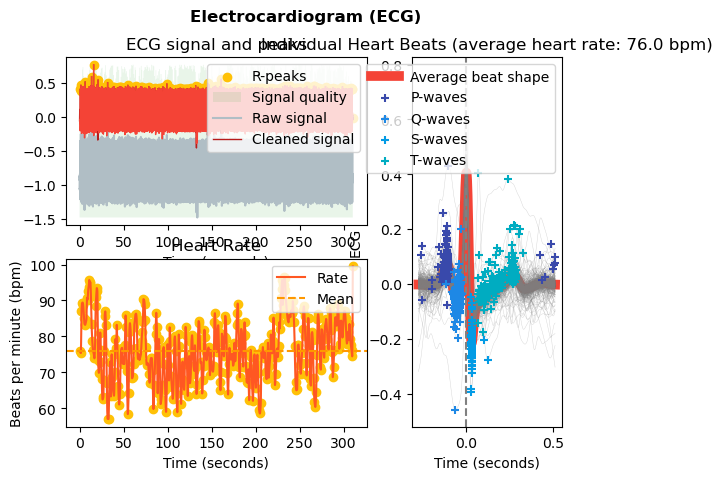

ECG analyze output of segment PB1 (only part2).stress2_ABBA:
  ECG_Rate_Mean             HRV_MeanNN               HRV_SDNN  \
0     75.973187  [[790.0255102040817]]  [[87.99944409406429]]   

               HRV_SDANN1             HRV_SDNNI1              HRV_SDANN2  \
0  [[19.978724750815548]]  [[85.87451326721899]]  [[20.445021802731397]]   

             HRV_SDNNI2 HRV_SDANN5 HRV_SDNNI5              HRV_RMSSD  ...  \
0  [[83.8894571346283]]    [[nan]]    [[nan]]  [[67.01690819975755]]  ...   

               HRV_SampEn             HRV_ShanEn             HRV_FuzzyEn  \
0  [[1.4678743481123135]]  [[7.653112340351856]]  [[1.1585246398873912]]   

                 HRV_MSEn               HRV_CMSEn              HRV_RCMSEn  \
0  [[1.3781320132376251]]  [[1.3955982405237763]]  [[2.1243666379767245]]   

                  HRV_CD                HRV_HFD                HRV_KFD  \
0  [[1.737726421566056]]  [[1.833581467202542]]  [[3.673272020460387]]   

                  HRV_LZC  
0  [[0.87905202

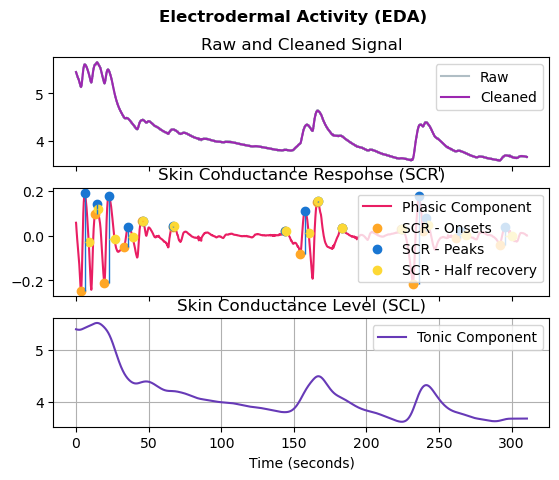

EDA of segment PB1 (only part2).stress2_ABBA:
   SCR_Peaks_N  SCR_Peaks_Amplitude_Mean  EDA_Tonic_SD  EDA_Sympathetic  \
0         15.0                  0.115548      0.473852          0.00303   

   EDA_SympatheticN  EDA_Autocorrelation  
0          0.000439             0.911171  
Segment PB1 (only part2).nf2_2D:


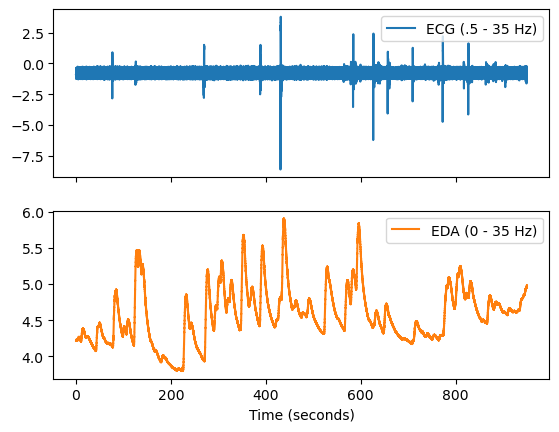

ECG of segment PB1 (only part2).nf2_2D:


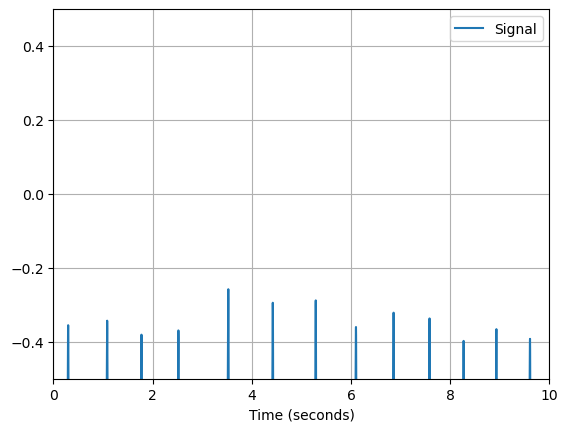

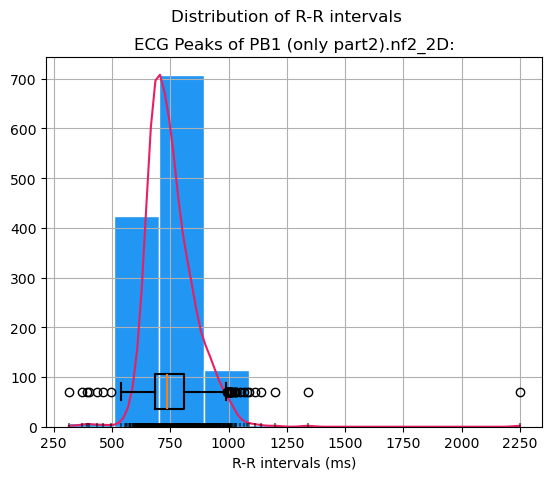

HRV of segment PB1 (only part2).nf2_2D:
   HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  HRV_SDANN2  HRV_SDNNI2  \
0  753.584591  107.65311   36.812212   97.845323   32.774701  100.351044   

   HRV_SDANN5  HRV_SDNNI5  HRV_RMSSD   HRV_SDSD  ...  HRV_IQRNN  HRV_SDRMSSD  \
0   30.864201  101.827938  98.565655  98.604848  ...      123.0     1.092197   

   HRV_Prc20NN  HRV_Prc80NN  HRV_pNN50  HRV_pNN20  HRV_MinNN  HRV_MaxNN  \
0        674.0        830.0  30.341541  65.687053      315.0     2249.0   

     HRV_HTI  HRV_TINN  
0  22.087719       0.0  

[1 rows x 25 columns]
0    753.584591
Name: HRV_MeanNN, dtype: float64
0    107.65311
Name: HRV_SDNN, dtype: float64
0    98.565655
Name: HRV_RMSSD, dtype: float64


In [ ]:
main()